In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit

In [2]:
N =50

In [3]:
# Random grid generation
init_random = np.random.random((N,N))
lattice_n = np.zeros((N,N))
lattice_n[init_random>=0.75]=1
lattice_n[init_random<0.75]=-1


init_random = np.random.random((N,N))
lattice_p = np.zeros((N,N))
lattice_p[init_random>=0.25]=1
lattice_p[init_random<0.25]=-1

init_random = np.random.random((N,N))
lattice_e = np.zeros((N,N))
lattice_e[init_random>=0.5]=1
lattice_e[init_random<0.5]=-1

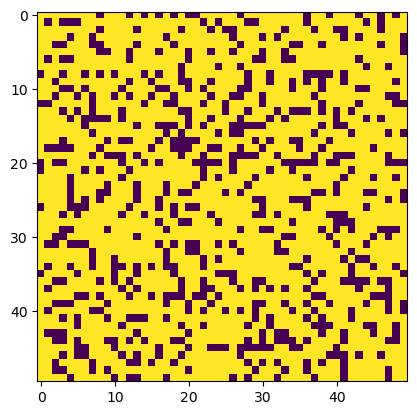

In [4]:
plt.imshow(lattice_p)

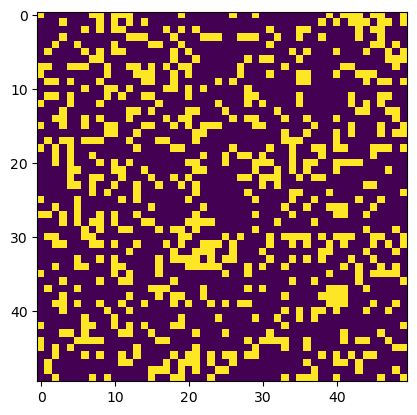

In [5]:
plt.imshow(lattice_n)

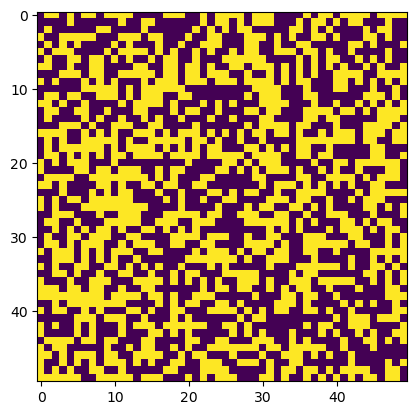

In [6]:
plt.imshow(lattice_e)

In [7]:
lattice = np.array([
    [- 1, -1,  -1],
    [-1,  1, -1],
    [ 1, -1,  1]
])

padded_lattice = np.pad(lattice, pad_width=1, mode='wrap')

print("Original lattice:")
print(lattice)
print("\nPadded lattice with periodic boundaries:")
print(padded_lattice)


Original lattice:
[[-1 -1 -1]
 [-1  1 -1]
 [ 1 -1  1]]

Padded lattice with periodic boundaries:
[[ 1  1 -1  1  1]
 [-1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1]
 [ 1  1 -1  1  1]
 [-1 -1 -1 -1 -1]]


In [8]:
def get_energy_microstate(lattice):
    kernel = np.array([
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ])

    padded_lattice = np.pad(lattice, pad_width=1, mode='wrap')
    convolved = np.zeros_like(lattice)

    rows, cols = lattice.shape
    for i in range(rows):
        for j in range(cols):
            region = padded_lattice[i:i+3, j:j+3]
            convolved[i, j] = np.sum(region * kernel)

    energy_matrix = -lattice * convolved
    #print(energy_matrix.shape)
    total_energy = np.sum(energy_matrix)

    return total_energy/2

In [9]:
get_energy_microstate(lattice_p)

-1212.0

In [10]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, T, energy):
    N = spin_arr.shape[0]
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)

    for i in range(0, times-1):
        for _ in range(N*N):
            x = np.random.randint(0, N)
            y = np.random.randint(0, N)

            spin_i = spin_arr[x, y]


            neighbors_sum = (spin_arr[(x+1)%N, y] +
                             spin_arr[(x-1)%N, y] +
                             spin_arr[x, (y+1)%N] +
                             spin_arr[x, (y-1)%N])

            dE = 2 * spin_i * neighbors_sum


            if dE <= 0 or np.random.random() < np.exp(-1/T * dE):
                spin_arr[x, y] = -spin_i
                energy += dE

        net_spins[i] = np.sum(spin_arr)
        net_energy[i] = energy

    return net_spins, net_energy


C:\Shriram\Anaconda\Lib\site-packages\numba\core\decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [11]:
def plot_energy_histogram(energies, T):
    plt.figure(figsize=(8,5))
    plt.hist(energies, bins=50, density=True, alpha=0.7, color='blue')
    plt.title(f'Energy Histogram of Sampled Metropolis Data at T={T}')
    plt.xlabel('Energy')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


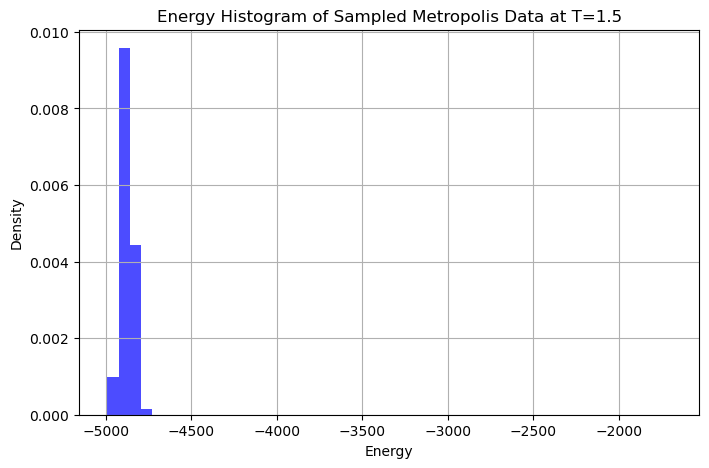

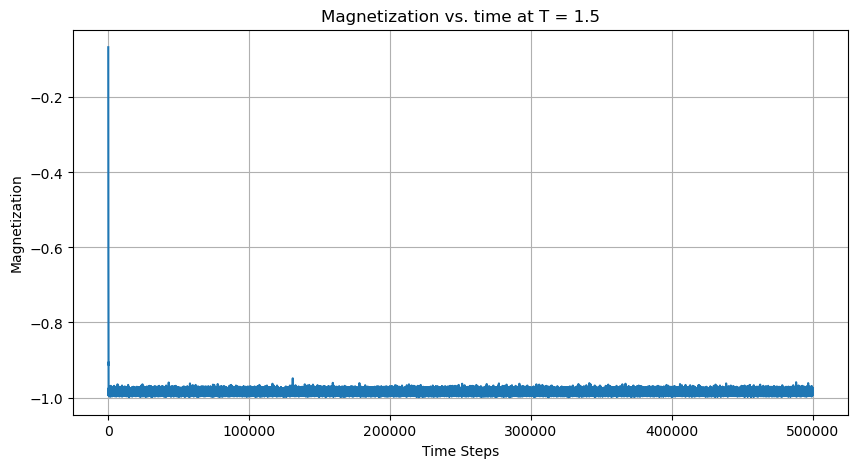

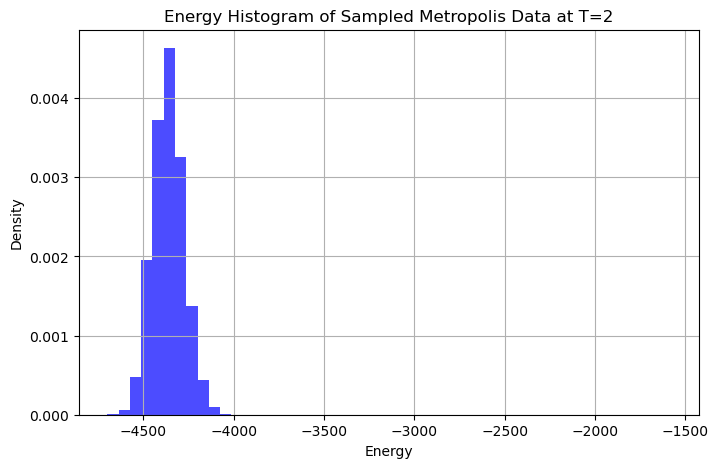

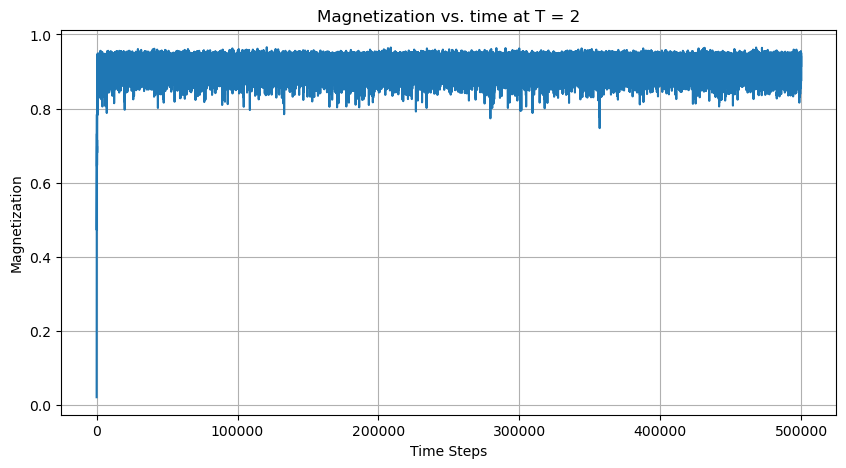

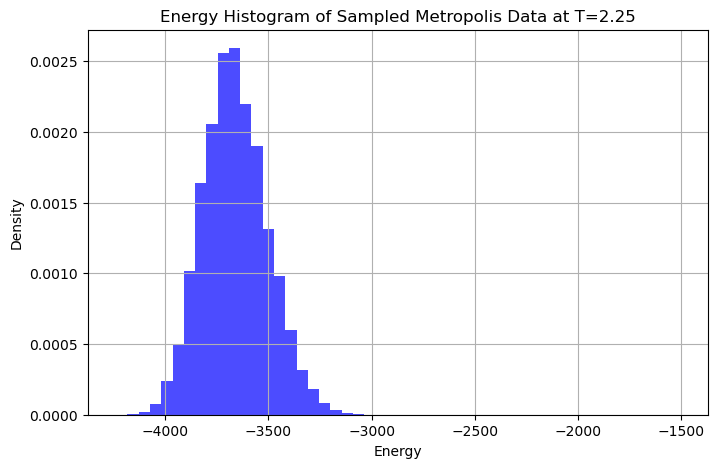

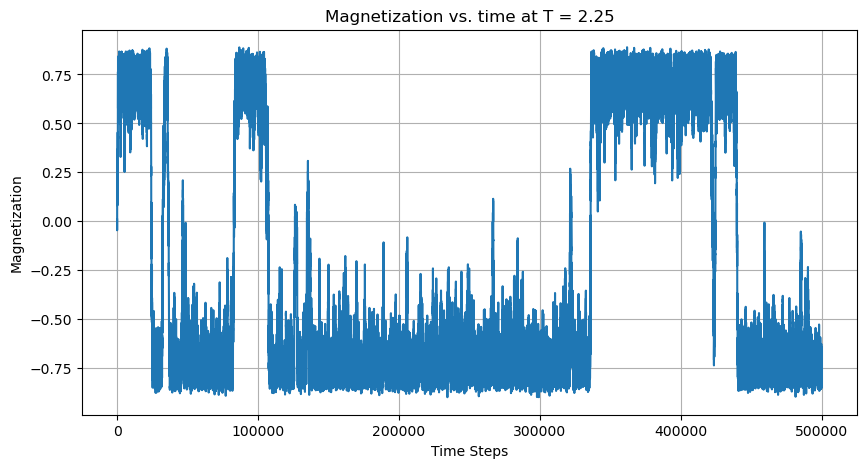

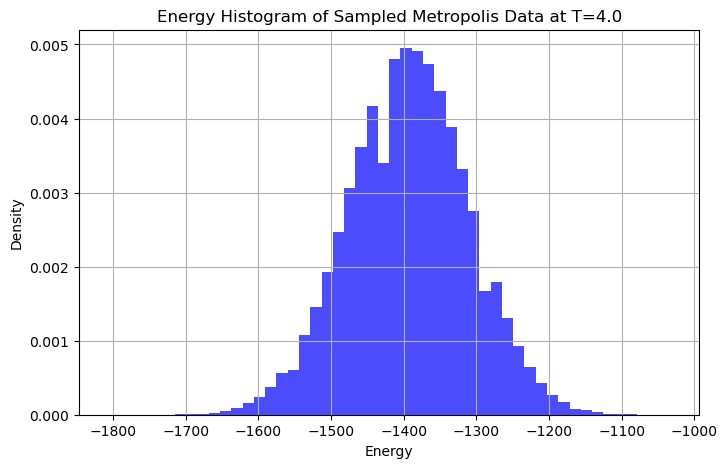

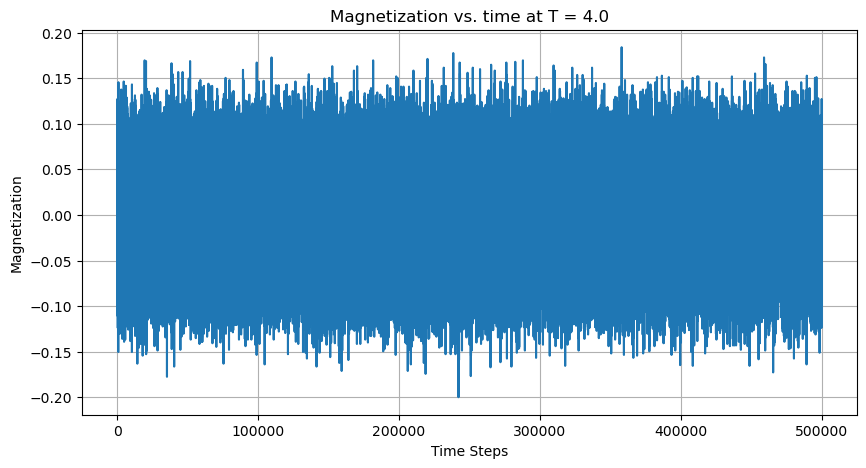

In [12]:
T_values = [1.5,2,2.25, 4.0]
results = []

for T in T_values:
    lattice = 2 * np.random.randint(0, 2, size=(N, N)) - 1
    initial_energy = get_energy_microstate(lattice)
    lattice = lattice.astype(np.float64)
    spins, energies = metropolis(lattice, 500000, T, initial_energy)
    plot_energy_histogram(energies,T)
    plt.figure(figsize=(10, 5))
    plt.plot(spins/N**2)
    plt.title(f"Magnetization vs. time at T = {T}")
    plt.xlabel("Time Steps")
    plt.ylabel("Magnetization")
    plt.grid(True)
    plt.show()


In [12]:
def get_spin_energy(lattice, Ts):
    ms = np.zeros(len(Ts))
    E_means = np.zeros(len(Ts))
    E_stds = np.zeros(len(Ts))
    for i, t in enumerate(Ts):
        spins, energies = metropolis(lattice, 20000, t, get_energy_microstate(lattice))
        ms[i] = spins[-20000:].mean()/N**2
        E_means[i] = energies[-20000:].mean()
        E_stds[i] = energies[-20000:].std()
    return ms, E_means, E_stds

Ts = np.arange(0.1, 10, 0.1)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, Ts)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, Ts)
ms_e, E_means_e, E_stds_e = get_spin_energy(lattice_e, Ts)

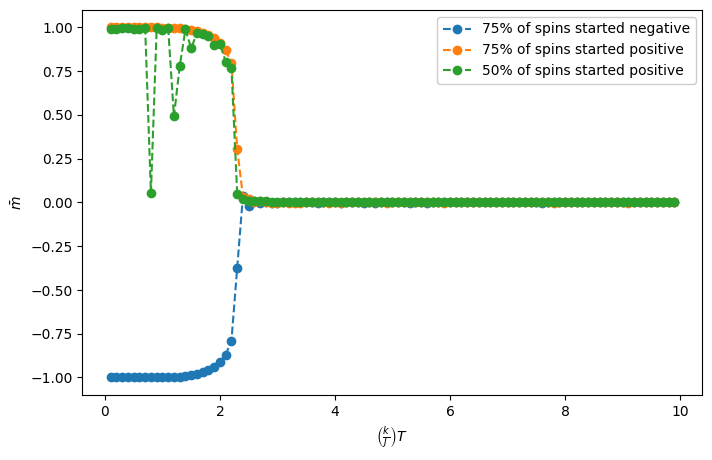

In [13]:
plt.figure(figsize=(8,5))
plt.plot(Ts, ms_n, 'o--', label='75% of spins started negative')
plt.plot(Ts, ms_p, 'o--', label='75% of spins started positive')
plt.plot(Ts, abs(ms_e), 'o--', label='50% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

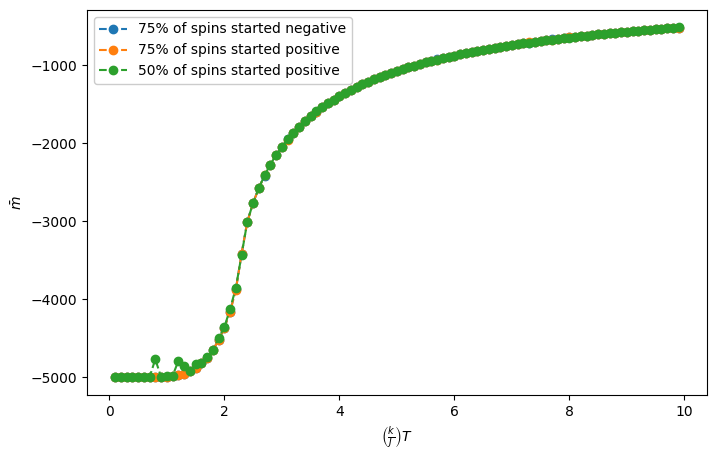

In [16]:
plt.figure(figsize=(8,5))
plt.plot(Ts, E_means_n, 'o--', label='75% of spins started negative')
plt.plot(Ts, E_means_p, 'o--', label='75% of spins started positive')
plt.plot(Ts, E_means_e, 'o--', label='50% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()